```
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip 
```

In [7]:
import urllib.request

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
urllib.request.urlretrieve(url, filename)

('jena_climate_2009_2016.csv.zip', <http.client.HTTPMessage at 0x2538a6e3970>)

In [1]:
import zipfile

with zipfile.ZipFile("jena_climate_2009_2016.csv.zip","r") as zip_ref:
    zip_ref.extractall()

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
# Imprime los encabezados y separa los datos del encabezado

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]
# Para tener solo los datos de la temperatura

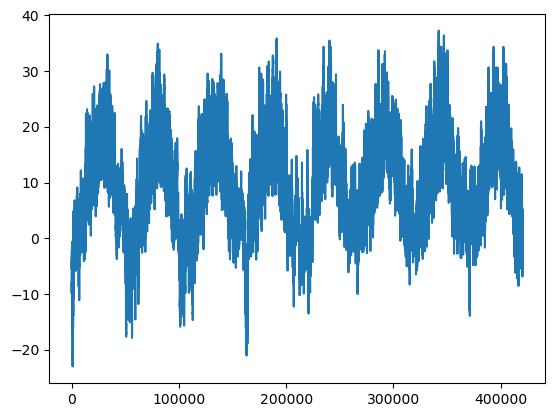

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature) #grafica en serie de tiempo de la temperatura

Como los datos con tomados cada 10 minutos tienen mucha resolución. Podemos graficar los primeros 10 días. 26*6=144 Es el numero correspondiente a un solo día.

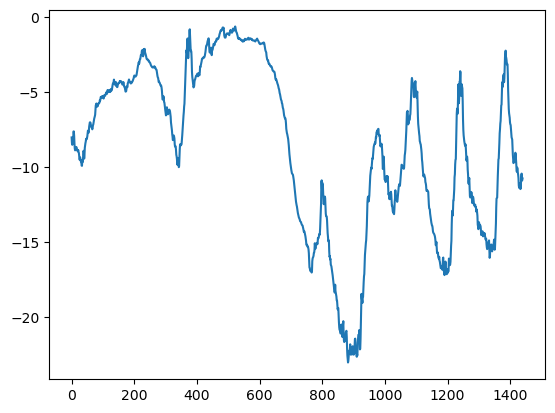

In [12]:
plt.plot(range(1440), temperature[:1440]) 

Analizar el siguiente código para identificar la funcionalidad de la función : keras.utils.timeseries_dataset_form_array()

In [13]:
from tensorflow import keras
import numpy as np
int_sequence = np.arange(10) #Generamos un array de enteros del 0 al 9
dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],    #secuencia para valores de x
    targets = int_sequence[3:], #secuencia para extraer los valores y
    sequence_length=3,  #tamano de las secuencias x
    batch_size=2,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)


for inputs, targets in dataset:
  print("series x")
  print(inputs)
  print("y")
  print(targets)

series x
tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int32)
y
tf.Tensor([3 4], shape=(2,), dtype=int32)
series x
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int32)
y
tf.Tensor([5 6], shape=(2,), dtype=int32)
series x
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int32)
y
tf.Tensor([7], shape=(1,), dtype=int32)


In [14]:
for inputs, targets in dataset:
   for i in range(inputs.shape[0]):
     print([int(x) for x in inputs[i]], int(targets[i]))
        # Esto es para ver los datos anteriores de una forma mas ordenada

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


## Tarea 
1. Genera secuencias x para entrenamiento (50%), validación (25%) y prueba (25%) de 120 elementos de longitud a partir de los datos de temperatura. Aquí hay un ejemplo de una forma de lograrlo para generar un conjunto de secuencias:


In [5]:
from tensorflow import keras
import numpy as np

total = len(temperature)
train = total // 2
val = (total - train) // 2
test = total - train - val

delay = 1 # pasos de tiempo para retroceder (predecir temperatura de mañana con datos de hoy)
sequence_length = 120 
sampling_rate = 1 # cada cuanto vas a tomar datos (en este caso cada muestra, o sea cada 10 min)
batch_size = 10

print("Totales =", total)
print("Entrenamiento =", train)
print("Validacion =", val)
print("Prueba =", test)

Totales = 420451
Entrenamiento = 210225
Validacion = 105113
Prueba = 105113


In [6]:
# Conjuntos de secuencias
# entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train)
# validacion
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train,
    end_index=train + val)
# test
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=val+train,
    end_index=None)

El reto en el código de arriba es simplemente calcular los valores de start_index y end_idex para obtener el número de secuencias x desadas.

Construye y entrena una red que estime la temperatura 10 pasos en el futuro. Puedes usar tanto Conv1D o bien LSTM
Prueba ahora como datos de entrada las demás variables como presión y las demás.
Aquí hay un ejemplo de como tendrías que constuir las series de tiempo para el último ejercicio:

# Conv 1D

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical

In [8]:
def slice(x, slice_length):
         return x[:, -slice_length:, :]

ks = 5
look_ahead =  delay

modeldil = Sequential()

modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1,
                           batch_input_shape=(None, None, 1)))
#modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
#modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
#modeldil.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))

modeldil.add(Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
modeldil.compile(optimizer='adam',loss='mean_squared_error')

histdil = modeldil.fit(train_dataset,
                    epochs=20,#tenia 200
                    batch_size=batch_size,
                    validation_data=val_dataset, verbose=0)

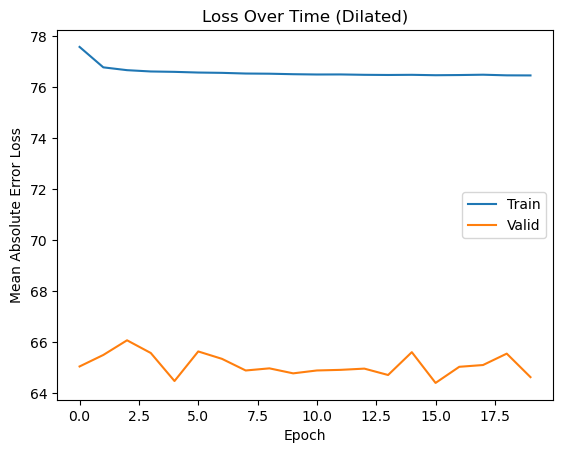

In [10]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

10500/10500 [==============================] - 25s 2ms/step


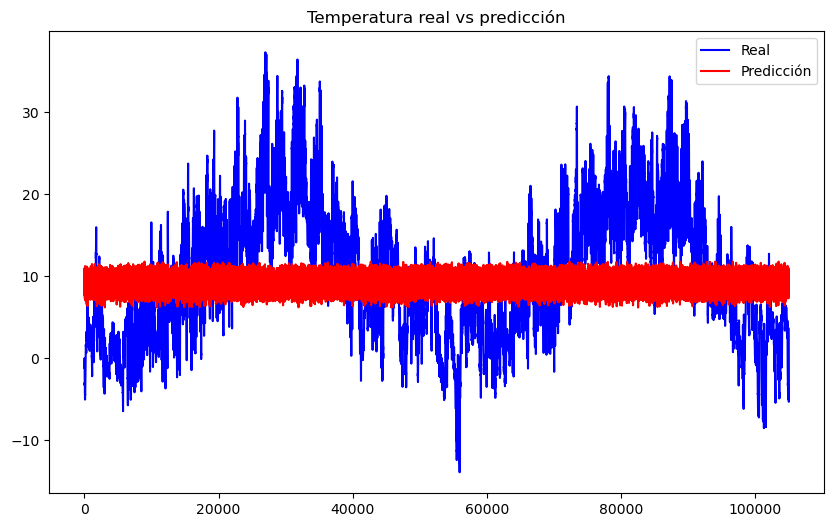

In [13]:
predictions = modeldil.predict(test_dataset)
predictions = predictions.flatten()
real_data = temperature[val+train:]
real_data = real_data[:len(predictions)]

plt.figure(figsize=(10,6))
plt.plot(real_data, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predicción')
plt.title('Temperatura real vs predicción')
plt.legend()
plt.show()


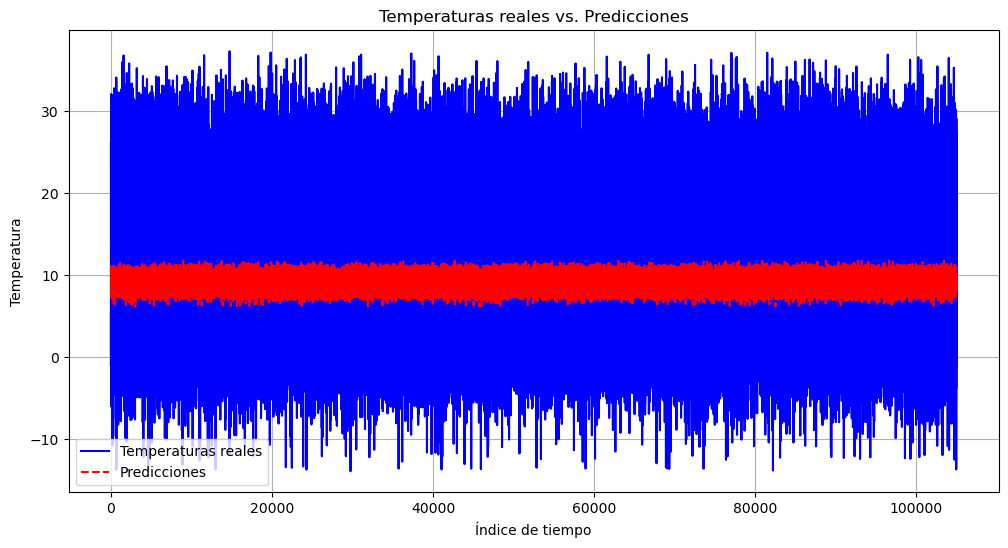

In [14]:
import matplotlib.pyplot as plt

# Extraer las temperaturas reales del conjunto de prueba
true_values = []
for item in test_dataset:
    true_values.extend(item[1].numpy())

# Crear una lista de índices para el eje x
indices = list(range(len(true_values)))

# Graficar las temperaturas reales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(indices, true_values, label='Temperaturas reales', color='blue')
plt.plot(indices, predictions, label='Predicciones', color='red', linestyle='--')
plt.xlabel('Índice de tiempo')
plt.ylabel('Temperatura')
plt.legend()
plt.title('Temperaturas reales vs. Predicciones')
plt.grid(True)
plt.show()


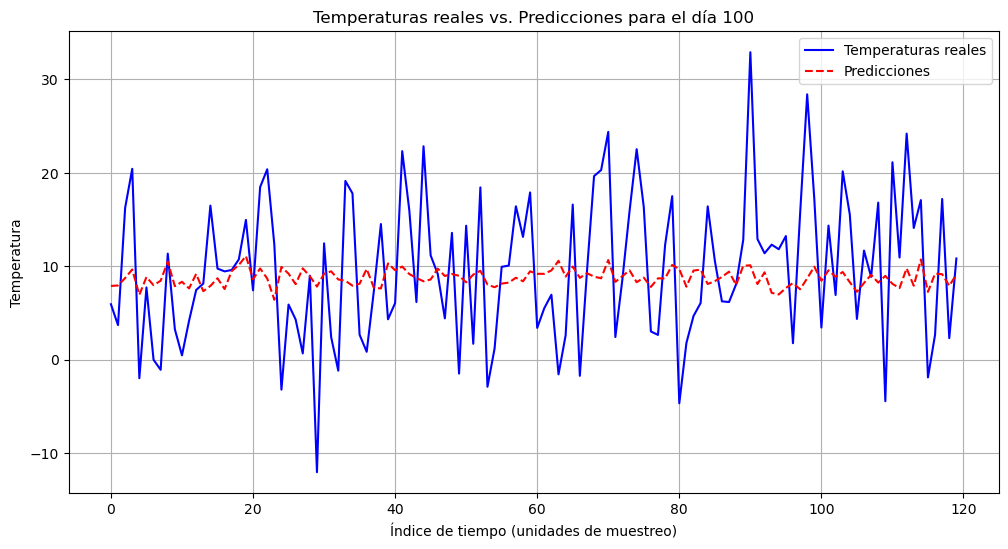

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Definir el día que deseas visualizar (por ejemplo, el día 100)
day_to_visualize = 100

# Obtener las temperaturas reales y las predicciones para ese día
true_values_day = true_values[day_to_visualize * sequence_length: (day_to_visualize + 1) * sequence_length]
predictions_day = predictions[day_to_visualize * sequence_length: (day_to_visualize + 1) * sequence_length]

# Crear una lista de índices para el eje x (correspondiente a ese día)
indices_day = list(range(len(true_values_day)))
plt.figure(figsize=(12, 6))
plt.plot(indices_day, true_values_day, label='Temperaturas reales', color='blue')
plt.plot(indices_day, predictions_day, label='Predicciones', color='red', linestyle='--')
plt.xlabel('Índice de tiempo (unidades de muestreo)')
plt.ylabel('Temperatura')
plt.legend()
plt.title(f'Temperaturas reales vs. Predicciones para el día {day_to_visualize}')
plt.grid(True)
plt.show()



In [19]:
val_dataset = gen_data()
res = modeldil.predict(X)
print('MSE for one step look-ahead', np.average((red[:,0,0] - Y[:,0,0])**2)) one step look ahead predict
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) #One step look-ahead prediction
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2))

SyntaxError: invalid syntax (146020382.py, line 3)

In [ ]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 10
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, modeldil, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
plt.ylim((-1,1))